In [2]:
!apt install xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install pyglet
!pip install gymnasium[classic_control]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  freeglut3 freeglut3-dev xvfb
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 983 kB of archives.
After this operation, 3,350 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freeglut3-dev amd64 2.8.1-3 [124 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.13 [785 kB]
Fetched 983 kB in 2s (428 kB/s)
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 124016 files and directories currently installed.)
P

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import matplotlib.pyplot as plt
import time

# HW07: Deep Q learning for a classic control problem



This homework will begin with a brief review of Q learning and the cartpole problem, adapted from https://www.tensorflow.org/agents/tutorials/0_intro_rl

Our goal is to train a neural network to balance a pole on a cart, where the neural net can choose to move the cart left or right. Here is an example of what we hope to learn:

![cartpole](https://i.imgur.com/5ziiZUD.gif)

# 1. Introduction

# 1.1 Q-Learning

- Q-Learning is based on the notion of a Q-function. 
- The Q-function (a.k.a the state-action value function) of a policy $\pi$, $Q^{\pi}(s, a)$, measures the **expected return obtained from state $s$ by taking action $a$ first and following policy $\pi$ thereafter**. 
    - Naively, we can use a table to store the $q$ value for all possible pairs of $(s,a)$ 
    - In more complicated cases, we can use a neural network representation. 
- The goal of Q-learning is to learn the optimal Q-function $Q^*(s,a)$, which satifeis the *Bellman* optimality equation: 
$\begin{equation}Q^\ast(s, a) = \mathbb{E}[ r + \gamma \max_{a'} Q^\ast(s', a') ]\end{equation}$
- Q-learning approaches this Bellman optimality by the **iterative update**:  $Q_{i+1}(s, a) \leftarrow \mathbb{E}\left[ r + \gamma \max_{a'} Q_{i}(s', a')\right]$
- It can be shown that this converges to the optimal $Q$-function, i.e. $Q_i \rightarrow Q^*$ as $i \rightarrow \infty$ (see the [DQN paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)).


## 1.2 DQN (Deep Q Network) 

- As is explained before, in many real-world problems there are enormouse state and/or action spaces and therefore tabular representation is insufficient (e.g. Computer Go has $10^{170}$ states)
- Therefore, we need to use a **deep neural network $Q(s,a,w)$**, where $w$ are the weights of a neural network, to represent the Q-function. This motivates DQN. 
- In DQN, the goal is to learn the weights $w$ such that $Q(s,a,w) \approx Q^\pi (s,a)$. This translates to minimizing the following **loss function** by the iterative update rule described above, 
$$L(w) = E\left[ \left( \color{red}{\textrm{target}} - Q(s,a,w) \right)^2\right] \qquad \qquad \cdots \qquad \qquad (1)$$
where $\color{red}{\textrm{target} = r+\gamma \max_{a'} Q(s', a', w)}$. 


In order for DQN to work well, there are two important tricks which are used in the training loop. Below, we'll try training without these tricks first (Q1-3), and then we will train again with them turned on (Q4).

- **Experience replay**: The experience replay uses a large experience buffer that contains a collection of experience tuples $(S,A,R,S')$. These tuples are gradually added to the buffer as the agent interacts with the environment. To optimize the loss function (1), at each step a small batch of tuples are sampled from the replay buffer and are used to compute a stochastic estimate of the loss. 

- **Target network** : The 
target network is a **copy** of the main neural network $Q$ and it is used to compute the target value in eq (1), while the main network is used to compute the actual q value $Q(s,a,w)$ in eq (1). 
It is important to highlight that only the parameters of the main network is trained, and the target network's parameters are **not trained** i.e. **freezed**, but they are **periodically synchronized** with the parameters of the main Q-network. 

## 1.3 DQN Algorithm

Putting together all the components, below is the pseudocode of the final algorithm with experience replay and the target network.

How does this algorithm change without experience replay and the target network?
 - Without experience replay, we would just store the $N$ (the batch size) previous actions, rewards, and transitions, and always train on those.
 - Without the target network, we would just have $\hat{Q}=Q$.

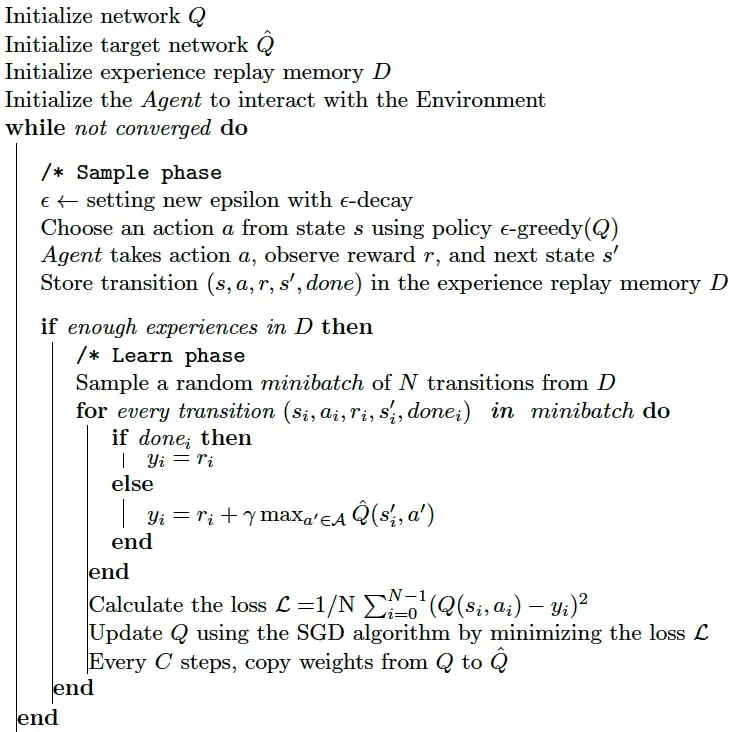

# 2. Implementing DQN for the Cartpole Problem 

Here, we will:

 - Implement the DQN training *without* using the target network $\hat{Q}$ or
   the experience replay trick (Q1-3)
 - Slightly modify our solutions to Q1-3 to add in the target network and 
   experience replay (Q4)
 - Think about what changed (Q5-6)

## The Cartpole Environment

The Cartpole environment is one of the most well known classic reinforcement learning problems ( the *"Hello, World!"* of RL). A pole is attached to a cart, which can move along a frictionless track. The pole starts upright and the goal is to prevent it from falling over by controlling the cart.  

*   The observation from the environment $s_t$ is a 4D vector representing the position and velocity of the cart, and the angle and angular velocity of the pole. 
*   The agent can control the system by taking one of 2 actions $a_t$: push the cart right (1) or left (0). 
*   A reward $r_{t+1} = 1$ is provided for every timestep that the pole remains upright. The episode ends when one of the following is true:
  * the pole tips over some angle limit
  * the cart moves outside of the world edges
  * 200 time steps pass. 

The goal of the agent is to learn a policy $\pi(a_t|s_t)$ so as to maximize the sum of rewards in an episode $\sum_{t=0}^{T} \gamma^t r_t$. Here $\gamma$ is a discount factor in $[0, 1]$ that discounts future rewards relative to immediate rewards. This parameter helps us focus the policy, making it care more about obtaining rewards quickly.

For lots more information about the cart pole Gym environment we will be using
when programming this problem, have a look here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/


In [4]:
# Load the cartpole environment
env = gym.make('CartPole-v1', new_step_api=False)

# Get the number of actions and the dimension of the observation space
num_actions = env.action_space.n
observation_dim = env.observation_space.shape[0]

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
# -- Parameters
# Discount factor for past rewards
gamma = 0.99  

# Epsilon-greedy decay parameters
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter

# This is the number of frames it will take to go from min to max epsilon
# Controls the rate of change of epsilon.
epsilon_greedy_frames = 20_000
epsilon_interval = epsilon_max - epsilon_min

# Size of each training batch
batch_size = 32  

# Make sure episodes don't last forever
max_steps_per_episode = 10000

# Train the model after 4 actions -- learning every step is slow and unstable.
update_after_actions = 4

# Other losses are sometimes used in DQNs (e.g. Huber for Atari)
loss_function = keras.losses.MeanSquaredError()

# Architecture for our feedforward nets
layer_sizes = [32, 32, 32]

In [6]:
def create_q_models(do_target=False):
    model = keras.Sequential(
        [layers.Dense(size, activation="relu") for size in layer_sizes]
        + [layers.Dense(num_actions, activation=None)]
    )
    if do_target:
        target = keras.Sequential(
            [layers.Dense(size, activation="relu") for size in layer_sizes]
            + [layers.Dense(num_actions, activation=None)]
        )
        return model, target
    
    return model

# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_models()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = model # create_q_model()


## Q1-3: Complete the following codes according to the pseudoalgorithm.

Here, we will not use the target network or the experience replay.
But, those details are not part of the code that we will ask you to write, so you may still follow the pseudoalgorithm above to complete Qs 1-3.

If your code is working, it should take about 400 episodes (~5 minutes) to run. It will print its progress as it goes and make plots of the reward for you. Don't be concerned if the reward goes down at the start, but do be concerned if it doesn't start to go up after 300 or 400 episodes.

1/1 [==============================] - 0s 13ms/step
running reward: 23.21 at episode 43, frame count 1000, greedy prob 0.04499999999996174, time spent so far 0.27m
1/1 [==============================] - 0s 16ms/step
running reward: 22.27 at episode 89, frame count 2000, greedy prob 0.08999999999992347, time spent so far 0.53m
1/1 [==============================] - 0s 13ms/step
Making plots after 100 episodes


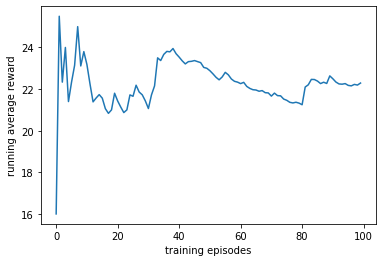

1/1 [==============================] - 0s 15ms/step
running reward: 22.72 at episode 132, frame count 3000, greedy prob 0.1349999999998852, time spent so far 0.79m
1/1 [==============================] - 0s 13ms/step
running reward: 24.55 at episode 169, frame count 4000, greedy prob 0.17999999999984695, time spent so far 1.05m
1/1 [==============================] - 0s 13ms/step
Making plots after 200 episodes


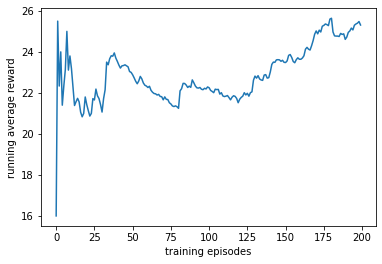

1/1 [==============================] - 0s 13ms/step
running reward: 25.77 at episode 209, frame count 5000, greedy prob 0.2249999999998087, time spent so far 1.32m
1/1 [==============================] - 0s 13ms/step
running reward: 29.27 at episode 234, frame count 6000, greedy prob 0.2699999999997704, time spent so far 1.58m
1/1 [==============================] - 0s 30ms/step
running reward: 32.63 at episode 256, frame count 7000, greedy prob 0.31499999999973216, time spent so far 1.88m
1/1 [==============================] - 0s 20ms/step
running reward: 36.69 at episode 282, frame count 8000, greedy prob 0.3599999999996939, time spent so far 2.33m
1/1 [==============================] - 0s 14ms/step
running reward: 41.62 at episode 299, frame count 9000, greedy prob 0.40499999999965564, time spent so far 2.63m
1/1 [==============================] - 0s 13ms/step
Making plots after 300 episodes


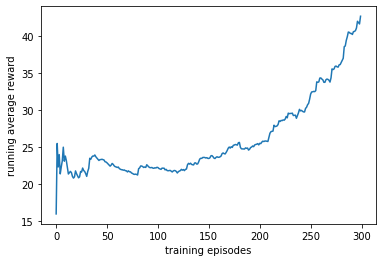

1/1 [==============================] - 0s 13ms/step
running reward: 46.55 at episode 315, frame count 10000, greedy prob 0.4499999999996174, time spent so far 2.91m
1/1 [==============================] - 0s 13ms/step
running reward: 50.65 at episode 331, frame count 11000, greedy prob 0.4949999999995791, time spent so far 3.21m
1/1 [==============================] - 0s 12ms/step
running reward: 54.87 at episode 347, frame count 12000, greedy prob 0.5399999999995901, time spent so far 3.50m
1/1 [==============================] - 0s 23ms/step
running reward: 60.77 at episode 354, frame count 13000, greedy prob 0.5849999999996074, time spent so far 3.79m
1/1 [==============================] - 0s 14ms/step
running reward: 67.26 at episode 360, frame count 14000, greedy prob 0.6299999999996246, time spent so far 4.10m
1/1 [==============================] - 0s 16ms/step
running reward: 74.81 at episode 369, frame count 15000, greedy prob 0.6749999999996419, time spent so far 4.41m
1/1 [=====

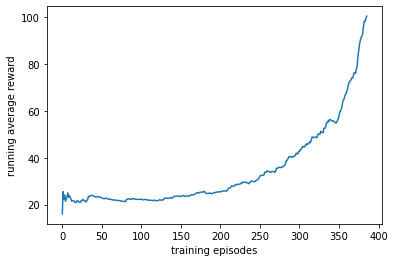

Solved at episode 386!


In [7]:
# -- Initialize training loop variables
optimizer = keras.optimizers.Adam()

# Store history of recent actions -- we will train on the most recent
# batch of actions, and always store `batch_size` previous steps
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward_history = []

running_reward = 0
episode_count = 0
frame_count = 0

# epsilon for epsilon-greedy. will be modified in the training loop.
epsilon = epsilon_max

# track the time spent training
tic = time.time()

# How often to print updates
log_interval = 1000

# Run until solved
while True:
    state = np.array(env.reset())
    episode_reward = 0

    # Episode loop
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)

        # Decay probability of taking random action
        # Q1: Implement epsilon decay
        # Epsilon should decay linearly from epsilon_max to epsilon_min
        # starting at epsilon_max when `frame_count==0`, and ending at 
        # epsilon_min when `frame_count==epsilon_greedy_frames`.

        ### Your code here ###
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)      
        ######################
       
        # Use epsilon-greedy for exploration
        # Q2: implement epsilon greedy.
        # With probability epsilon, set action to a randomly chosen action
        # Else, use the best action according to model (not target_model).
        ### Your code here ###
        if epsilon > np.random.rand(1)[0]:
          action = np.random.choice(num_actions)
        else:
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy() 

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(np.array(action))
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Limit the state and reward history
        if len(rewards_history) > batch_size:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) >= batch_size:

            # Get indices of samples for replay buffers
            # indices = np.random.choice(range(len(done_history)), size=batch_size)
            indices = np.arange(batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array(state_history)
            state_next_sample = np.array(state_next_history)
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor( #done_history)
                [float(done_history[i]) for i in indices]
            )
    
            # Q3: Computing the DQN loss.
            # We will break this into 3 steps.
    
            # Q3.a: use model to predict the Q values at the minibatch of next
            # states, `state_next_sample`.
            # Since we are not using a target network, this is slightly different
            # from the Qhat(s', a') in the pseudocode above: use the model,
            # not model_target, to predict Q.
            
            ### Your code here ###
            Q_hat = model_target.predict(state_next_sample)
            ######################
            
            # Q3.b: Find the maximum reward at these future states
            # This corresponds to max_{a'} Qhat(s', a') in the pseudocode above
            # Take the maximum over actions of Q_hat
            
            ### Your code here ###
            future_rewards = tf.reduce_max(Q_hat, axis=1)
            ######################

            # Q3.c: Compute the target y in the loss
            # target = (reward at this sample) + (discount factor) * (optimal reward at future sample)
            # This corresponds to y_i in the pseudocode above.
            
            ### Your code here ###
            target = rewards_history + gamma * future_rewards
            ######################
            
            # If final frame set the last value to -1
            target = target * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            # for actions that were actually taken
            masks = tf.one_hot(action_history, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                # Apply the masks to the Q-values to get the Q-value for action taken
                q_values = model(state_sample)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(target, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if not frame_count % log_interval and len(done_history) >= batch_size:
            # Log details
            toc = time.time()
            template = "running reward: {:.2f} at episode {}, frame count {}, greedy prob {}, time spent so far {:.2f}m"
            print(template.format(running_reward, episode_count, frame_count, 1 - epsilon, (toc - tic) / 60))

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 100 or running_reward > 100:
        print("Making plots after", episode_count, "episodes")
        plt.figure()
        plt.plot(running_reward_history)
        plt.ylabel("running average reward")
        plt.xlabel("training episodes")
        plt.show()
        plt.close("all")

    # Condition to consider the task solved
    # The agent gets +1 reward every frame it survives, and OpenAI's criterion
    # for considering cartpole solved is 475 -- but 100 means we have learned
    # something and we can get there fast enough.
    if running_reward > 100:
        print("Solved at episode {}!".format(episode_count))
        break

## Q4: Train again with experience replay and the target network

Here, we ask you to paste your solutions from above into the corresponding locations in the training code, with some slight modifications.
See the questions in the code below for details!

In [8]:
## -- Experience replay and target model logic
# Maximum replay length
# Note: The Deepmind Atari paper suggests 1000000 however this causes memory issues
max_memory_length = 100000

# How often to update the target network
update_target_network = 1000

# Create a new model so that we can train from scratch
# Also initialize a target model with the same architecture
model, model_target = create_q_models(do_target=True)

1/1 [==============================] - 0s 13ms/step
running reward: 22.36 at episode 44, frame count 1000, greedy prob 0.04499999999996174
1/1 [==============================] - 0s 15ms/step
running reward: 22.46 at episode 89, frame count 2000, greedy prob 0.08999999999992347
1/1 [==============================] - 0s 14ms/step
100


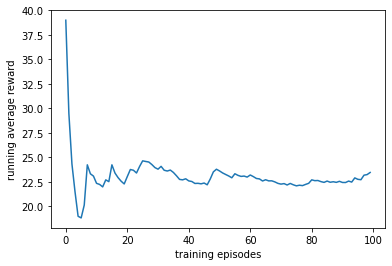

1/1 [==============================] - 0s 18ms/step
running reward: 25.45 at episode 120, frame count 3000, greedy prob 0.1349999999998852
1/1 [==============================] - 0s 14ms/step
running reward: 27.66 at episode 151, frame count 4000, greedy prob 0.17999999999984695
1/1 [==============================] - 0s 13ms/step
running reward: 32.39 at episode 179, frame count 5000, greedy prob 0.2249999999998087
1/1 [==============================] - 0s 14ms/step
200


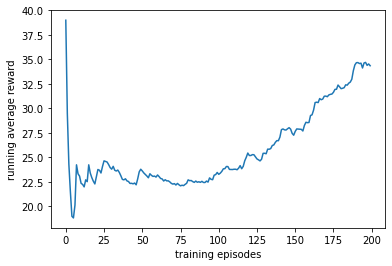

1/1 [==============================] - 0s 17ms/step
running reward: 34.40 at episode 206, frame count 6000, greedy prob 0.2699999999997704
1/1 [==============================] - 0s 15ms/step
running reward: 38.87 at episode 225, frame count 7000, greedy prob 0.31499999999973216
1/1 [==============================] - 0s 14ms/step
running reward: 41.75 at episode 243, frame count 8000, greedy prob 0.3599999999996939
1/1 [==============================] - 0s 18ms/step
running reward: 45.67 at episode 261, frame count 9000, greedy prob 0.40499999999965564
1/1 [==============================] - 0s 15ms/step
running reward: 51.61 at episode 272, frame count 10000, greedy prob 0.4499999999996174
1/1 [==============================] - 0s 16ms/step
running reward: 59.07 at episode 281, frame count 11000, greedy prob 0.4949999999995791
1/1 [==============================] - 0s 13ms/step
running reward: 65.79 at episode 287, frame count 12000, greedy prob 0.5399999999995901
1/1 [=================

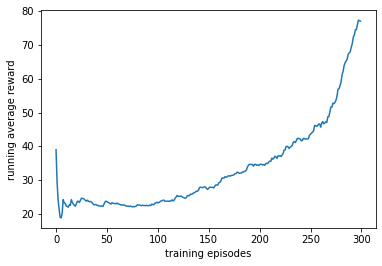

1/1 [==============================] - 0s 14ms/step
running reward: 79.75 at episode 303, frame count 14000, greedy prob 0.6299999999996246
1/1 [==============================] - 0s 15ms/step
running reward: 88.90 at episode 307, frame count 15000, greedy prob 0.6749999999996419
1/1 [==============================] - 0s 15ms/step
running reward: 96.55 at episode 310, frame count 16000, greedy prob 0.7199999999996591
1/1 [==============================] - 0s 14ms/step
312


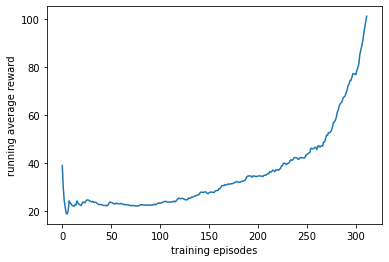

Solved at episode 312!


In [9]:
# -- Initialize training loop variables
optimizer = keras.optimizers.Adam()

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward_history = []

running_reward = 0
episode_count = 0
frame_count = 0

# epsilon for epsilon-greedy. will be modified in the training loop.
epsilon = epsilon_max

# Run until solved
while True:
    state = np.array(env.reset())
    episode_reward = 0

    # Episode loop
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)

        # Decay probability of taking random action
        # Q4.a: Implement epsilon decay
        # This code should be exactly the same as your code above in Q1
        ### Your code here ###
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)   
        ######################

        # Use epsilon-greedy for exploration
        # Q4.b: implement epsilon greedy.
        # This code should be exactly the same as your code above in Q2
        ### Your code here ###
        if epsilon > np.random.rand(1)[0]:
          # Take random action
          action = np.random.choice(num_actions)
        else: 
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy()

        ######################

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(np.array(action))
        state_next = np.array(state_next)
        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )
    
            # Computing the DQN loss.
            # We will break this into 3 steps.
    
            # Q4.c: Predicting Q values
            # <!> This requires some changes from above! <!>
            # Rather than using `model`, use `model_target` to predict the Q
            # values at the minibatch of next states, `state_next_sample`.
            # This is exactly Qhat(s', a') in the pseudocode above
            ### Your code here ###
            Q_hat = model_target.predict(state_next_sample) 
            ######################

            # Q4.d: Find the maximum reward at these future states
            # This should be the same as your code above.
            ### Your code here ###
            future_rewards = tf.reduce_max(Q_hat, axis=1) 
            ######################

            # Q4.e: Compute the target y in the loss
            # This should be the same as your code above.
            ### Your code here ###
            target = rewards_sample + gamma * future_rewards 
            ######################
          
            # If final frame set the last value to -1
            target = target * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            # for actions that were actually taken
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                # Apply the masks to the Q-values to get the Q-value for action taken
                q_values = model(state_sample)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(target, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0 and len(done_history) > batch_size:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, greedy prob {}"
            print(template.format(running_reward, episode_count, frame_count, 1 - epsilon))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 100 or running_reward > 100:
        print(episode_count)
        plt.figure()
        plt.plot(running_reward_history)
        plt.ylabel("running average reward")
        plt.xlabel("training episodes")
        plt.show()
        plt.close("all")

    # Condition to consider the task solved
    # The agent gets +1 reward every frame it survives, and OpenAI's criterion
    # for considering cartpole solved is 475 -- but 100 means we have learned
    # something and we can get there fast enough.
    if running_reward > 100:
        print("Solved at episode {}!".format(episode_count))
        break

### Q5. Why does experience replay help? 

Hint: Optimizing the loss function in eq(1) is essentially a supervised learning problem, which requires i.i.d. training samples 

####### YOUR ANSWER HERE ########

Experience replay is a crucial component of off-policy deep reinforcement learning algorithms, improving the sample efficiency and stability of training by storing the previous environment interactions experienced by an agent. Replay buffers “replay” experiences for an agent, allowing them to revisit and train on their memories. Experience replay uses previous experience more effectively by learning multiple times. When gaining real-world experience is costly, this is key, and you can make the most of it. Q-learning updates are incremental and do not converge quickly, so multiple passes with the same data are beneficial, especially given the same state, action pair, immediate results (reward, next state) When the variance is small.

Better convergence behavior when training function approximators. Part of the reason is that the data are more like IID. The data assumed in most supervised learning convergence proofs.
#################################


### Q6. Why does (freezing ) the target network help? 

Hint: Q-Learning is essentially updating a guess with a guess through the iterative update, which can potentially lead to harmful correlations: The loss function computes two q values, and they can be very similar since they are just one step away. This makes it very hard for the neural network to distinguish between them, 

######### YOUR ANSWER HERE #############

Q-learning is value-based reinforcement learning algorithm that learns “optimal” probability distribution between state-action that will maximize it’s long term discounted reward over a sequence of timesteps. The problem is that you can affect the action values for the very next state you will be in instead of guaranteeing them to be stable as they are in Q-learning. Thus, using a stable target network as your error measure is one way of combating this effect. By giving your network more time to consider many actions that have taken place recently instead of updating all the time, it hopefully finds a more robust model before you start using it to make actions.
########################################